# Rate Networks

In [1]:
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ipywidgets as widgets
import scipy

%matplotlib inline

# Settings for the figures
plt.style.use(plt.style.available[20])
plt.style.use("https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/plots_style.txt")

try:
    import brian2
except ImportError:
    !pip install brian2
    
from brian2 import *
prefs.codegen.target = 'numpy'


\begin{equation}
F(x;\alpha,\theta) = \left(1+\text{e}^{-\frac{x-\theta}{\alpha}}\right)^{-1} - \left(1+\text{e}^{\frac{\theta}{\alpha}}\right)^{-1}
\end{equation}

interactive(children=(FloatSlider(value=0.2, description='alpha', max=1.0, min=0.01, step=0.01), IntSlider(val…

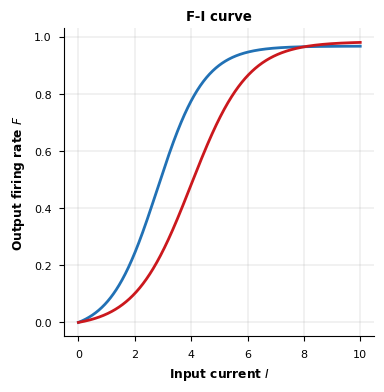

In [16]:
def nonlinearity_f(x, alpha, theta):    
    return (1 + np.exp(-alpha*(x - theta)))**-1 - (1 + np.exp(alpha*theta))**-1

fig, ax = plt.subplots(figsize = (4,4))
X = np.linspace(0,10,1000)
ax.plot(X, nonlinearity_f(X, alpha=1.2, theta=2.8), color = '#2171B5')
ax.plot(X, nonlinearity_f(X, alpha=1.0, theta=4.0), c='#CB181D')
ax.set(
    title = 'F-I curve',
    xlabel = 'Input current $I$',
    ylabel = 'Output firing rate $F$',
);


def interactive_f(alpha=0.2, theta=40):
    
    x_max = 80
    fig, ax = plt.subplots(figsize = (14,8))
    X = np.linspace(-0.1,x_max,100)
    ax.plot(X, nonlinearity_f(X, alpha=alpha, theta=theta), color='#6baed6', linewidth = 3)
    
    y_theta = nonlinearity_f(theta, alpha=alpha, theta=theta)
    
    ax.plot([theta,theta],[0,y_theta],
           linestyle = '--', c = '#e34a33', linewidth=1, label = r'threshold $\theta$')
    
    # we want to visualize the gain of the 
    
    diff = 8
    
    ax.plot([theta-diff,theta+diff],[y_theta-diff*alpha/4, y_theta+diff*alpha/4],
           linestyle = '--', c = 'k', linewidth=1, label = r'linear function with gain $\alpha/4$')
    
    ax.set(
        title = 'F-I curve',
        xlabel = 'Input current',
        ylabel = 'Output rate',
        ylim = [-0.05,1.05],
        xlim = [-0.05*x_max,x_max*1.05]
    );
    ax.legend()
    
widgets.interactive(interactive_f, alpha = (0.01,1,0.01), theta=(0,60,10))

Text(0, 0.5, 'firing rate $r$')

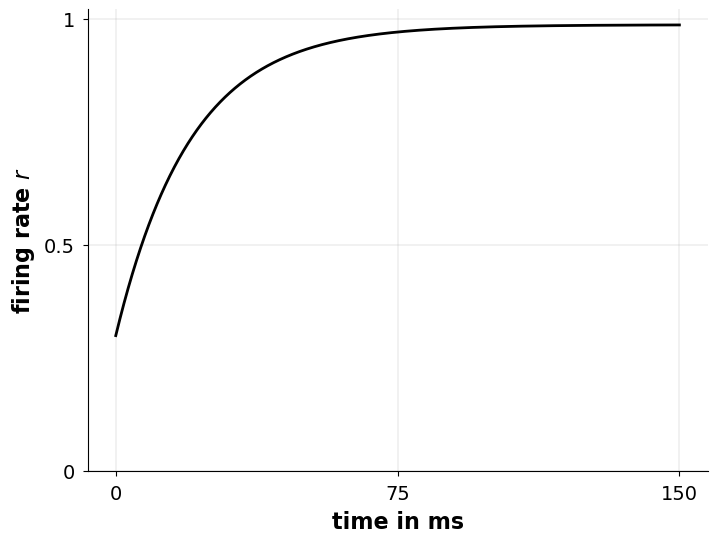

In [17]:
r_0 = 0.3
I_ext = 20

fig, ax = plt.subplots()

nonlinearity_f

r_list = [r_0]
t_list = [0]
dt = 0.1
tau = 20
for ii in range(1500):
    t_list.append(t_list[-1]+dt)
    r_list.append(r_list[-1] + dt*(-r_list[-1]+nonlinearity_f(I_ext,alpha=0.5,theta=10))/tau)

ax.plot(t_list, r_list, color='k')
ax.set_xticks([0,75,150])
ax.set_xticklabels([0,75,150],fontsize=14)
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,0.5,1],fontsize=14)
ax.set_xlabel('time in ms', fontsize=16)
ax.set_ylabel('firing rate $r$', fontsize=16)

\begin{align}
\tau_E \frac{dr_E}{dt} &= -r_E + F(w_{EE}r_E -w_{EI}r_I + I_E;\alpha_E,\theta_E) \\
\tau_I \frac{dr_I}{dt} &= -r_I + F(w_{IE}r_E -w_{II}r_I + I_I;\alpha_I,\theta_I) \qquad (1)
\end{align}

\begin{align}
\tau_E \frac{dr_E}{dt} &= -r_E + F_E(w_{EE}r_E -w_{EI}r_I + I_E) \\
\tau_I \frac{dr_I}{dt} &= -r_I + F_I(w_{IE}r_E -w_{II}r_I + I_I) \qquad (1)
\end{align}

Text(0, 0.5, '$\\frac{dr}{dt}$')

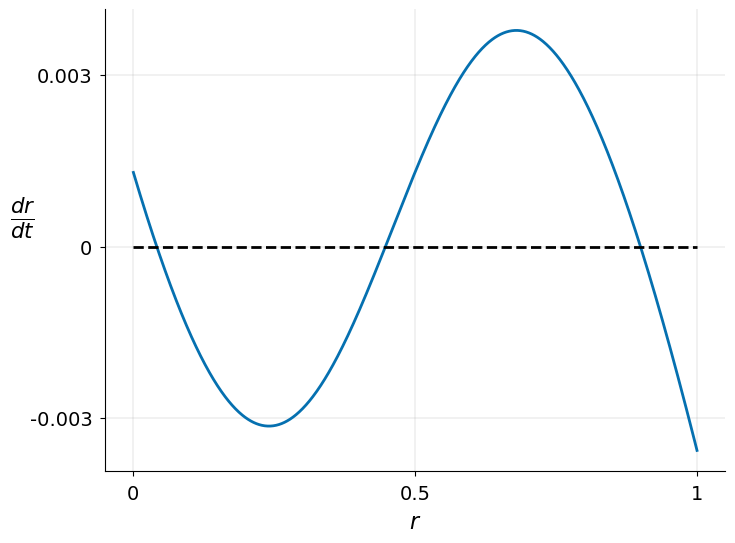

In [18]:
def compute_drdt(r, I_ext, w, alpha, theta, tau, **other_pars):
  """Given parameters, compute dr/dt as a function of r.

  Args:
    r (1D array) : Average firing rate of the excitatory population
    I_ext, w, a, theta, tau (numbers): Simulation parameters to use
    other_pars : Other simulation parameters are unused by this function

  Returns
    drdt function for each value of r
  """
  # Calculate drdt
  drdt = (-r + nonlinearity_f(w * r + I_ext, alpha, theta)) / tau

  return drdt


# Define a vector of r values and the simulation parameters
r = np.linspace(0, 1, 1000)

# Compute dr/dt
drdt = compute_drdt(r, I_ext = 0.5, w = 5, alpha = 1.2, theta = 2.8, tau = 20)

fig, ax = plt.subplots()
ax.plot(r, drdt)
ax.plot([0,1],[0,0],linestyle = '--', color = 'k')

x_ticks = [0,0.5,1]
y_ticks = [-0.003, 0, 0.003]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks,fontsize=14)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks,fontsize=14)
ax.set_xlabel('$r$', fontsize=16, fontweight='bold')
ax.set_ylabel(r'$\frac{dr}{dt}$', fontsize=22, rotation=0, fontweight='bold')

Text(0, 0.5, 'firing rate $r$')

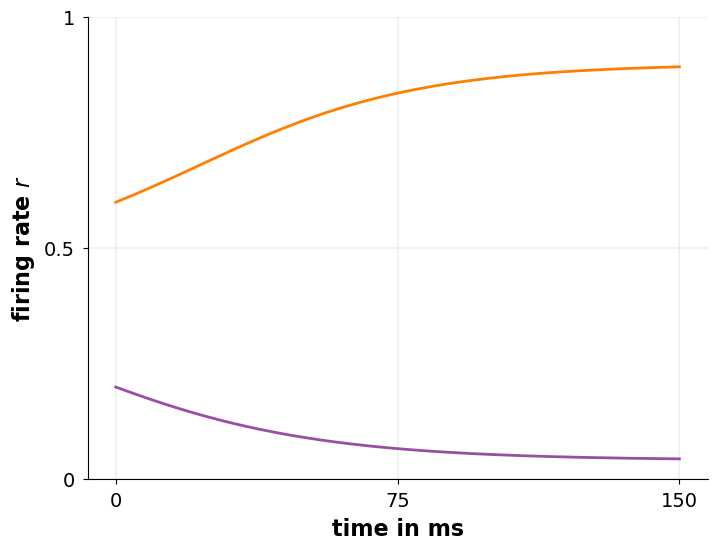

In [19]:


fig, ax = plt.subplots()



r_0 = 0.2
I_ext = 0.5
w=5
r_list = [r_0]
t_list = [0]
dt = 0.1
tau = 20
for ii in range(1500):
    t_list.append(t_list[-1]+dt)
    r_list.append(r_list[-1] + dt*(-r_list[-1] + nonlinearity_f(w*r_list[-1]+I_ext,alpha=1.2,theta=2.8))/tau)

ax.plot(t_list, r_list, color='#984ea3')

r_0 = 0.6
r_list = [r_0]
t_list = [0]
for ii in range(1500):
    t_list.append(t_list[-1]+dt)
    r_list.append(r_list[-1] + dt*(-r_list[-1] + nonlinearity_f(w*r_list[-1]+I_ext,alpha=1.2,theta=2.8))/tau)

ax.plot(t_list, r_list, color='#ff7f00')



ax.set_xticks([0,75,150])
ax.set_xticklabels([0,75,150],fontsize=14)
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,0.5,1],fontsize=14)
ax.set_xlabel('time in ms', fontsize=16)
ax.set_ylabel('firing rate $r$', fontsize=16)

Text(0, 0.5, 'firing rate $r$')

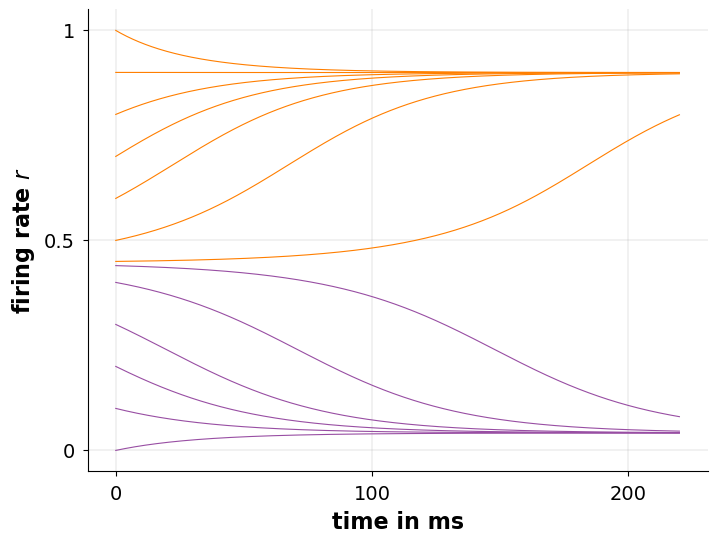

In [20]:
fig, ax = plt.subplots()



for r_0 in [0, 0.1, 0.2, 0.3, 0.4, 0.44]:
    I_ext = 0.5
    w=5
    r_list = [r_0]
    t_list = [0]
    dt = 0.1
    tau = 20
    for ii in range(2200):
        t_list.append(t_list[-1]+dt)
        r_list.append(r_list[-1] + dt*(-r_list[-1] + nonlinearity_f(w*r_list[-1]+I_ext,alpha=1.2,theta=2.8))/tau)

    ax.plot(t_list, r_list, color='#984ea3', linewidth = 0.8)

for r_0 in [0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    r_list = [r_0]
    t_list = [0]
    for ii in range(2200):
        t_list.append(t_list[-1]+dt)
        r_list.append(r_list[-1] + dt*(-r_list[-1] + nonlinearity_f(w*r_list[-1]+I_ext,alpha=1.2,theta=2.8))/tau)

    ax.plot(t_list, r_list, color='#ff7f00', linewidth = 0.8)



ax.set_xticks([0,100, 200])
ax.set_xticklabels([0,100,200],fontsize=14)
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,0.5,1],fontsize=14)
ax.set_xlabel('time in ms', fontsize=16)
ax.set_ylabel('firing rate $r$', fontsize=16)

In [60]:
class EI_network(object):
    """
    This class can create E-I networks, run simulations and visualize the results
    """
    def __init__(self, 
                    w_EE = 9,
                    w_EI = 4,
                    w_II = 13,
                    w_IE = 11,

                    tau_E = 20,
                    tau_I = 10,

                    alpha_E = 1.2,
                    theta_E = 2.8,

                    alpha_I = 1.0,
                    theta_I = 4.0,

                    dt = 1
    ):
        '''This function is executed when we create an object from that class'''
        super(EI_network, self).__init__()
         
        self.w_EE = w_EE 
        self.w_EI = w_EI 
        self.w_II = w_II 
        self.w_IE = w_IE 

        self.tau_E = tau_E 
        self.tau_I = tau_I 

        self.alpha_E = alpha_E 
        self.theta_E = theta_E 
        self.alpha_I = alpha_I 
        self.theta_I = theta_I 
        self.dt = dt   
    
    
        self.r_E_list = []
        self.r_I_list = []
        self.t_list = []

    
    def dr_dt(self, r_E, r_I, I_E, I_I):

        input_current_E = self.w_EE * r_E - self.w_EI * r_I + I_E 
        drE_dt = dt * (- r_E + nonlinearity_f(input_current_E, alpha=self.alpha_E, theta=self.theta_E))/self.tau_E

        input_current_I = self.w_IE * r_E - self.w_II * r_I + I_I 
        drI_dt = dt * (- r_I + nonlinearity_f(input_current_I, alpha=self.alpha_I, theta=self.theta_I))/self.tau_I

        return drE_dt, drI_dt
    
    def run_simulation(self, r_E0, r_I0, I_E = 0, I_I = 0, timesteps=201):    

        if len(self.t_list) == 0:
            self.t_list.append(0)
            self.r_E_list.append(r_E0)
            self.r_I_list.append(r_I0)

       
        
        for ii in range(timesteps):
            
            r_E = self.r_E_list[-1]
            r_I = self.r_I_list[-1]
            
            dr_E_dt, dr_I_dt = self.dr_dt(r_E, r_I, I_E, I_I)
            
            # store in lists
            self.r_E_list.append(r_E + dr_E_dt)
            self.r_I_list.append(r_I + dr_I_dt)
            self.t_list.append(self.t_list[-1]+dt)


    def show_sim_results_current_v_time_lecture_plot(self, ax = None, linestyle='-'):
        
        if ax == None:
            fig, ax = plt.subplots()
            x_ticks = [0,100,200]
            y_ticks = [0,0.5,1]
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(x_ticks,fontsize=14)
            ax.set_yticks(y_ticks)
            ax.set_yticklabels(y_ticks,fontsize=14)
            ax.set_xlabel('time in ms', fontsize=16)
            ax.set_ylabel('firing rate $r$', fontsize=16)
            ax.set(
                ylim = [-0.1,1.1])

        

        ax.plot(self.t_list, self.r_E_list, color='#2171B5', linewidth = 1.5, linestyle = linestyle)
        ax.plot(self.t_list, self.r_I_list, color='#CB181D', linewidth = 1.5, linestyle = linestyle)
        
        
        return ax
        
        
    def show_sim_results_phase_plane(self, ax = None, color = '#984ea3' ):
        
        if ax == None:
            fig, ax = plt.subplots()
            x_ticks = [0,0.5, 1]
            y_ticks = [0,0.25,0.5]
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(x_ticks,fontsize=14)
            ax.set_yticks(y_ticks)
            ax.set_yticklabels(y_ticks,fontsize=14)
            ax.set_xlabel('Excitatory rate $r_E$', fontsize=16)
            ax.set_ylabel('Inhibitory rate $r_I$', fontsize=16)

        ax.plot(self.r_E_list, self.r_I_list, linewidth = 1.2, color = color)
        
        
        return ax



<AxesSubplot:xlabel='Excitatory rate $r_E$', ylabel='Inhibitory rate $r_I$'>

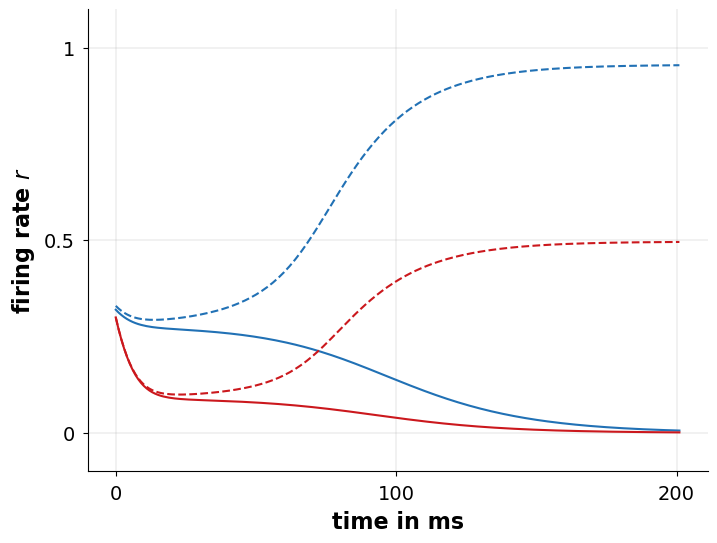

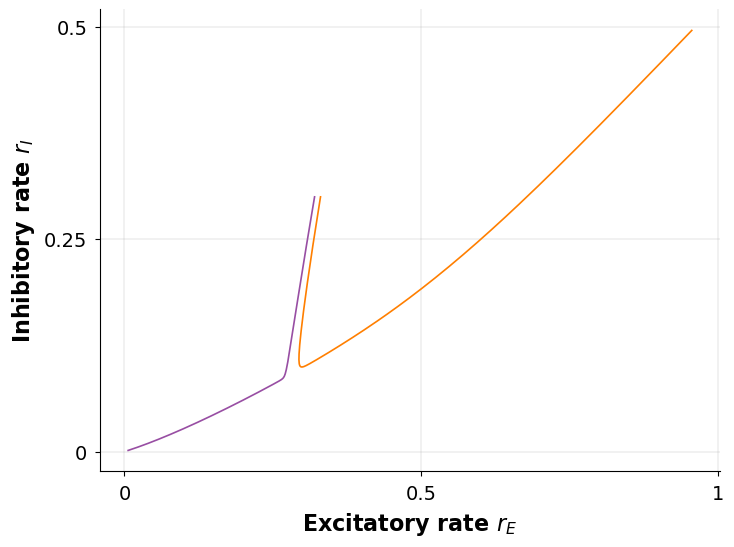

In [61]:
lecture_network_1 = EI_network()
lecture_network_1.run_simulation(r_E0 = 0.32, r_I0 = 0.3)
ax1 = lecture_network_1.show_sim_results_current_v_time_lecture_plot(linestyle = '-')
ax2 = lecture_network_1.show_sim_results_phase_plane( color = '#984ea3')

lecture_network_2 = EI_network()
lecture_network_2.run_simulation(r_E0 = 0.33, r_I0 = 0.3)
lecture_network_2.show_sim_results_current_v_time_lecture_plot(ax = ax1, linestyle = '--')
lecture_network_2.show_sim_results_phase_plane(ax = ax2, color = '#ff7f00')


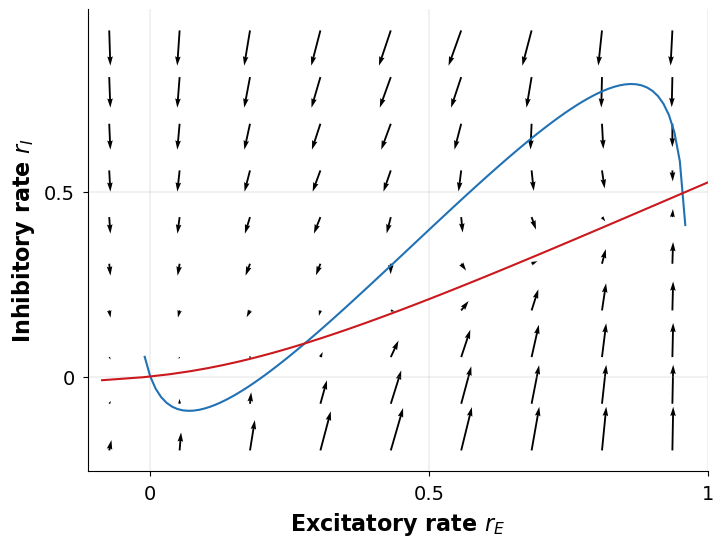

In [22]:
# to_remove solution
def F_inv(x, a, theta):
  """
  Args:
    x         : the population input
    a         : the gain of the function
    theta     : the threshold of the function

  Returns:
    F_inverse : value of the inverse function
  """

  # Calculate Finverse (ln(x) can be calculated as np.log(x))
  F_inverse = -1/a * np.log((x + (1 + np.exp(a * theta))**-1)**-1 - 1) + theta

  return F_inverse


x = np.linspace(1e-6, 1, 100)
# plot_FI_inverse(x, a=1, theta=3)

# to_remove solution
def get_E_nullcline(rE, a_E, theta_E, wEE, wEI, I_ext_E, **other_pars):
  """
  Solve for rI along the rE from drE/dt = 0.

  Args:
    rE    : response of excitatory population
    a_E, theta_E, wEE, wEI, I_ext_E : Wilson-Cowan excitatory parameters
    Other parameters are ignored

  Returns:
    rI    : values of inhibitory population along the nullcline on the rE
  """
  # calculate rI for E nullclines on rI
  rI = 1 / wEI * (wEE * rE - F_inv(rE, a_E, theta_E) + I_ext_E)

  return rI


def get_I_nullcline(rI, a_I, theta_I, wIE, wII, I_ext_I, **other_pars):
  """
  Solve for E along the rI from dI/dt = 0.

  Args:
    rI    : response of inhibitory population
    a_I, theta_I, wIE, wII, I_ext_I : Wilson-Cowan inhibitory parameters
    Other parameters are ignored

  Returns:
    rE    : values of the excitatory population along the nullcline on the rI
  """
  # calculate rE for I nullclines on rI
  rE = 1 / wIE * (wII * rI + F_inv(rI, a_I, theta_I) - I_ext_I)

  return rE


# Set parameters
Exc_null_rE = np.linspace(-0.01, 0.96, 100)
Inh_null_rI = np.linspace(-.01, 0.8, 100)

# Compute nullclines
Exc_null_rI = get_E_nullcline(Exc_null_rE, a_E = alpha_E, theta_E = theta_E, wEE = w_EE, wEI=w_EI, I_ext_E=I_E)
Inh_null_rE = get_I_nullcline(Inh_null_rI, a_I = alpha_I, theta_I = theta_I, wII = w_II, wIE=w_IE, I_ext_I=I_I)

fig, ax = plt.subplots()

ax.plot(Exc_null_rE,Exc_null_rI, color='#2171B5', linewidth = 1.5, label = 'E-nullcline')
ax.plot(Inh_null_rE,Inh_null_rI, color='#CB181D', linewidth = 1.5, label = 'I-nullcline')
x_ticks = [0,0.5, 1]
y_ticks = [0,0.5,1]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks,fontsize=14)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks,fontsize=14)
ax.set_xlabel('Excitatory rate $r_E$', fontsize=16)
ax.set_ylabel('Inhibitory rate $r_I$', fontsize=16)
ax.set_xlim([np.min(Inh_null_rE)*1.3,1])


def EIderivs(rE, rI,
             tau_E, a_E, theta_E, wEE, wEI, I_ext_E,
             tau_I, a_I, theta_I, wIE, wII, I_ext_I,
             **other_pars):
  """Time derivatives for E/I variables (dE/dt, dI/dt)."""

  # Compute the derivative of rE
  drEdt = (-rE + nonlinearity_f(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E

  # Compute the derivative of rI
  drIdt = (-rI + nonlinearity_f(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I

  return drEdt, drIdt


EI_grid = np.linspace(-0.2, 1., 20)
rE, rI = np.meshgrid(EI_grid, EI_grid)
drEdt, drIdt = EIderivs(rE, rI, tau_E = tau_E, a_E = alpha_E, theta_E = theta_E, wEE = w_EE, wEI = w_EI, I_ext_E = I_E,
                                tau_I = tau_I, a_I = alpha_I, theta_I = theta_I, wIE = w_IE, wII = w_II, I_ext_I = I_I)
n_skip = 2
plt.quiver(rE[::n_skip, ::n_skip], rI[::n_skip, ::n_skip],
         drEdt[::n_skip, ::n_skip], drIdt[::n_skip, ::n_skip],
         angles='xy', scale_units='xy', scale=1, facecolor='k', width = 0.003)

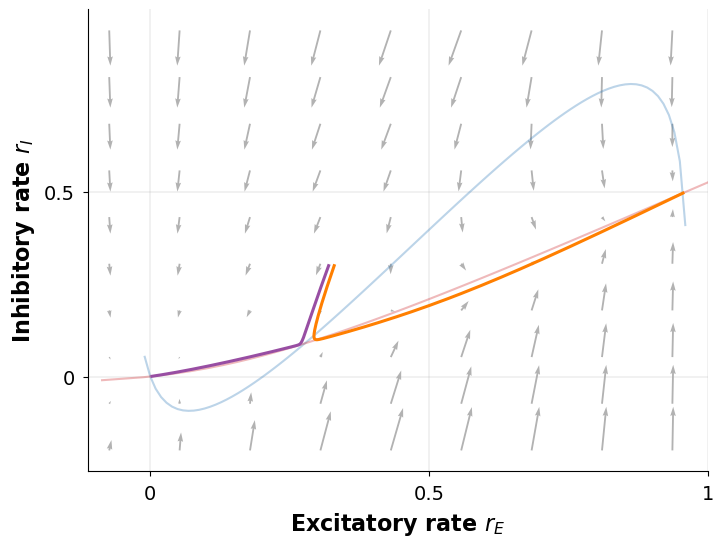

In [23]:

# Set parameters
Exc_null_rE = np.linspace(-0.01, 0.96, 100)
Inh_null_rI = np.linspace(-.01, 0.8, 100)

# Compute nullclines
Exc_null_rI = get_E_nullcline(Exc_null_rE, a_E = alpha_E, theta_E = theta_E, wEE = w_EE, wEI=w_EI, I_ext_E=I_E)
Inh_null_rE = get_I_nullcline(Inh_null_rI, a_I = alpha_I, theta_I = theta_I, wII = w_II, wIE=w_IE, I_ext_I=I_I)

fig, ax = plt.subplots()


x_ticks = [0,0.5, 1]
y_ticks = [0,0.5,1]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks,fontsize=14)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks,fontsize=14)
ax.set_xlabel('Excitatory rate $r_E$', fontsize=16)
ax.set_ylabel('Inhibitory rate $r_I$', fontsize=16)
ax.set_xlim([np.min(Inh_null_rE)*1.3,1])

EI_grid = np.linspace(-0.2, 1., 20)
rE, rI = np.meshgrid(EI_grid, EI_grid)
drEdt, drIdt = EIderivs(rE, rI, tau_E = tau_E, a_E = alpha_E, theta_E = theta_E, wEE = w_EE, wEI = w_EI, I_ext_E = I_E,
                                tau_I = tau_I, a_I = alpha_I, theta_I = theta_I, wIE = w_IE, wII = w_II, I_ext_I = I_I)
n_skip = 2
plt.quiver(rE[::n_skip, ::n_skip], rI[::n_skip, ::n_skip],
         drEdt[::n_skip, ::n_skip], drIdt[::n_skip, ::n_skip],
         angles='xy', scale_units='xy', scale=1, facecolor='k', width = 0.003, alpha = 0.3)

ax.plot(Exc_null_rE,Exc_null_rI, color='#2171B5', linewidth = 1.5, label = 'E-nullcline', alpha = 0.3)
ax.plot(Inh_null_rE,Inh_null_rI, color='#CB181D', linewidth = 1.5, label = 'I-nullcline', alpha = 0.3)


t_list, r_E_list, r_I_list = run_E_I_simulation(r_E_0 = 0.32, r_I_0 = 0.3)

ax.plot(r_E_list, r_I_list, linewidth = 2.2, color = '#984ea3')

t_list, r_E_list, r_I_list = run_E_I_simulation(r_E_0 = 0.33, r_I_0 = 0.3)

ax.plot(r_E_list, r_I_list, linewidth = 2.2, color = '#ff7f00')

In [24]:
def make(w_EE = 9, w_EI = 4, w_II = 13, w_IE = 11,tau_E = 20, tau_I = 20,
        alpha_E = 1.2,
    theta_E = 2.8, I_E = 0,
    I_I = 0):

    
    



    

    alpha_I = 1.0
    theta_I = 4.0

    # Set parameters
    Exc_null_rE = np.linspace(-0.01, 0.96, 100)
    Inh_null_rI = np.linspace(-.01, 1, 100)

    # Compute nullclines
    Exc_null_rI = get_E_nullcline(Exc_null_rE, a_E = alpha_E, theta_E = theta_E, wEE = w_EE, wEI=w_EI, I_ext_E=I_E)
    Inh_null_rE = get_I_nullcline(Inh_null_rI, a_I = alpha_I, theta_I = theta_I, wII = w_II, wIE=w_IE, I_ext_I=I_I)

    fig, ax = plt.subplots()

    ax.plot(Exc_null_rE,Exc_null_rI, color='#2171B5', linewidth = 1.5, label = 'E-nullcline')
    ax.plot(Inh_null_rE,Inh_null_rI, color='#CB181D', linewidth = 1.5, label = 'I-nullcline')
    x_ticks = [0,0.5, 1]
    y_ticks = [0,0.5,1]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks,fontsize=14)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticks,fontsize=14)
    ax.set_xlabel('Excitatory rate $r_E$', fontsize=16)
    ax.set_ylabel('Inhibitory rate $r_I$', fontsize=16)
#     ax.set_xlim([np.min(Inh_null_rE)*1.3,1])
    EI_grid = np.linspace(-0.2, 1., 20)
    rE, rI = np.meshgrid(EI_grid, EI_grid)
    drEdt, drIdt = EIderivs(rE, rI, tau_E = tau_E, a_E = alpha_E, theta_E = theta_E, wEE = w_EE, wEI = w_EI, I_ext_E = I_E,
                                    tau_I = tau_I, a_I = alpha_I, theta_I = theta_I, wIE = w_IE, wII = w_II, I_ext_I = I_I)
    n_skip = 2
    plt.quiver(rE[::n_skip, ::n_skip], rI[::n_skip, ::n_skip],
             drEdt[::n_skip, ::n_skip], drIdt[::n_skip, ::n_skip],
             angles='xy', scale_units='xy', scale=1, facecolor='k', width = 0.003)

widgets.interactive(make)

interactive(children=(IntSlider(value=9, description='w_EE', max=27, min=-9), IntSlider(value=4, description='…

[(-0.1, 1.1)]

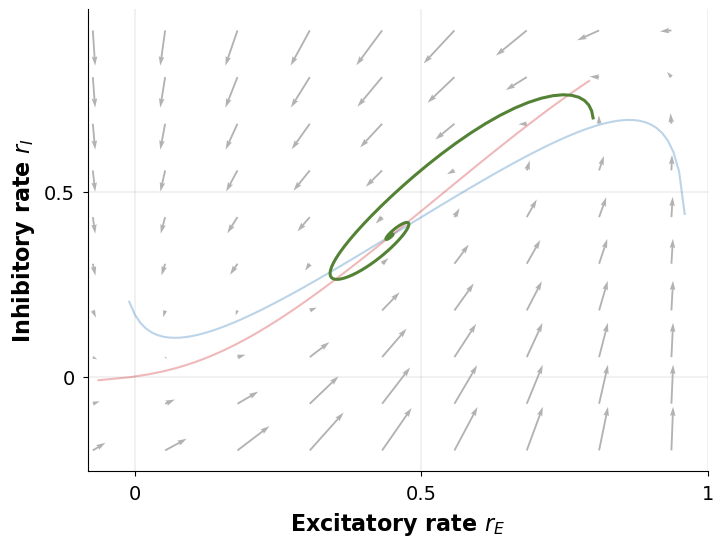

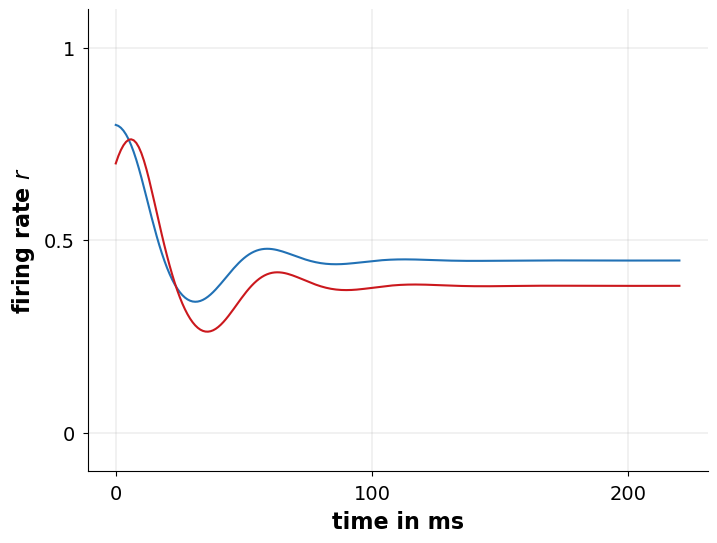

In [25]:
w_EE = 9 
w_EI = 6
w_II = 7
w_IE = 14
tau_E = 10 
tau_I = 10
alpha_E = 1.2
theta_E = 2.8
I_E = 1
I_I = 0


# Set parameters
Exc_null_rE = np.linspace(-0.01, 0.96, 100)
Inh_null_rI = np.linspace(-.01, 0.8, 100)

# Compute nullclines
Exc_null_rI = get_E_nullcline(Exc_null_rE, a_E = alpha_E, theta_E = theta_E, wEE = w_EE, wEI=w_EI, I_ext_E=I_E)
Inh_null_rE = get_I_nullcline(Inh_null_rI, a_I = alpha_I, theta_I = theta_I, wII = w_II, wIE=w_IE, I_ext_I=I_I)

fig, ax = plt.subplots()


x_ticks = [0,0.5, 1]
y_ticks = [0,0.5,1]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks,fontsize=14)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks,fontsize=14)
ax.set_xlabel('Excitatory rate $r_E$', fontsize=16)
ax.set_ylabel('Inhibitory rate $r_I$', fontsize=16)
ax.set_xlim([np.min(Inh_null_rE)*1.3,1])

EI_grid = np.linspace(-0.2, 1., 20)
rE, rI = np.meshgrid(EI_grid, EI_grid)
drEdt, drIdt = EIderivs(rE, rI, tau_E = tau_E, a_E = alpha_E, theta_E = theta_E, wEE = w_EE, wEI = w_EI, I_ext_E = I_E,
                                tau_I = tau_I, a_I = alpha_I, theta_I = theta_I, wIE = w_IE, wII = w_II, I_ext_I = I_I)
n_skip = 2
plt.quiver(rE[::n_skip, ::n_skip], rI[::n_skip, ::n_skip],
         drEdt[::n_skip, ::n_skip], drIdt[::n_skip, ::n_skip],
         angles='xy', scale_units='xy', scale=1, facecolor='k', width = 0.003, alpha = 0.3)

ax.plot(Exc_null_rE,Exc_null_rI, color='#2171B5', linewidth = 1.5, label = 'E-nullcline', alpha = 0.3)
ax.plot(Inh_null_rE,Inh_null_rI, color='#CB181D', linewidth = 1.5, label = 'I-nullcline', alpha = 0.3)


t_list, r_E_list, r_I_list = run_E_I_simulation(r_E_0 = 0.8, r_I_0 = 0.7)

ax.plot(r_E_list, r_I_list, linewidth = 2.2, color = '#548235')


fig, ax = plt.subplots()

ax.plot(t_list, r_E_list, color='#2171B5', linewidth = 1.5)
ax.plot(t_list, r_I_list, color='#CB181D', linewidth = 1.5)




x_ticks = [0,100, 200]
y_ticks = [0,0.5,1]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks,fontsize=14)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks,fontsize=14)
ax.set_xlabel('time in ms', fontsize=16)
ax.set_ylabel('firing rate $r$', fontsize=16)
ax.set(
    ylim = [-0.1,1.1])

[(-0.1, 1.1)]

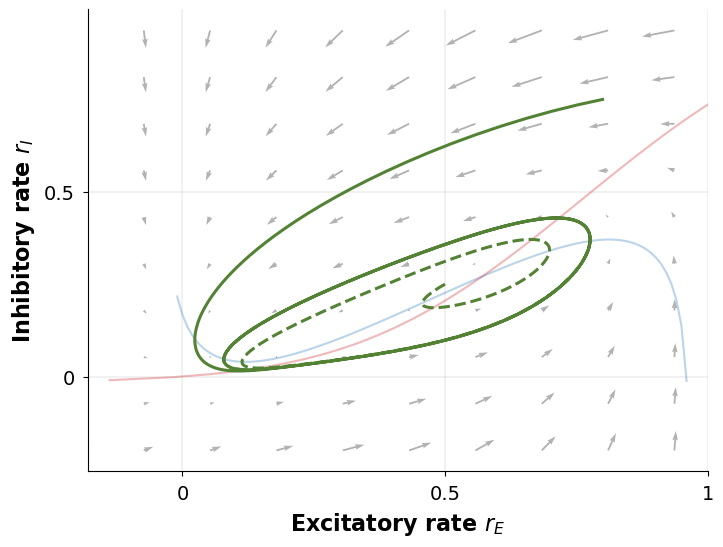

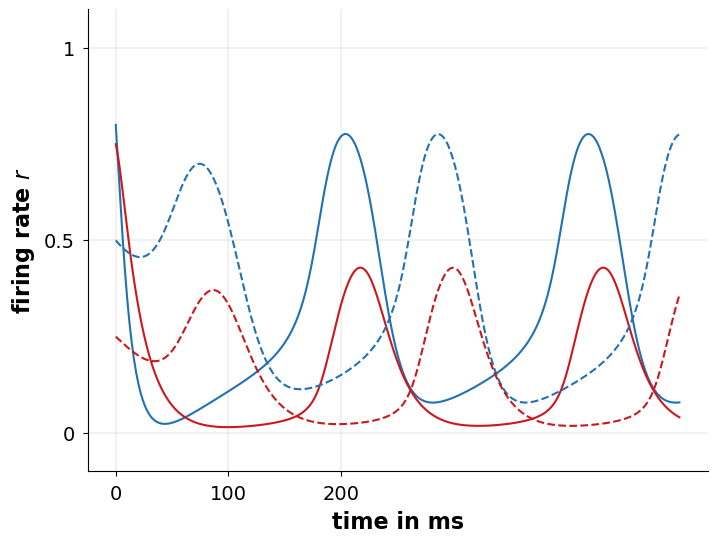

In [26]:
# 'tau_E': 1.0, 'a_E': 1.2, 'theta_E': 2.8, 
# 'tau_I': 2.0, 'a_I': 1.0, 'theta_I': 4.0, 
# 'wEE': 6.4, 'wEI': 4.8, 'wIE': 6.0, 
# 'wII': 1.2, 'I_ext_E': 0.8, 'I_ext_I': 0.0, 
# 'T': 100.0, 'dt': 0.1, 'rE_init': 0.25, 'rI_init': 0.25
                
w_EE = 6.4 
w_EI = 4.8
w_II = 1.2
w_IE = 6
tau_E = 10 
tau_I = 20
alpha_E = 1.2
theta_E = 2.8
alpha_I = 1
theta_I = 4.0
I_E = 0.8
I_I = 0


# Set parameters
Exc_null_rE = np.linspace(-0.01, 0.96, 100)
Inh_null_rI = np.linspace(-.01, 0.8, 100)

# Compute nullclines
Exc_null_rI = get_E_nullcline(Exc_null_rE, a_E = alpha_E, theta_E = theta_E, wEE = w_EE, wEI=w_EI, I_ext_E=I_E)
Inh_null_rE = get_I_nullcline(Inh_null_rI, a_I = alpha_I, theta_I = theta_I, wII = w_II, wIE=w_IE, I_ext_I=I_I)

fig, ax = plt.subplots()


x_ticks = [0,0.5, 1]
y_ticks = [0,0.5,1]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks,fontsize=14)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks,fontsize=14)
ax.set_xlabel('Excitatory rate $r_E$', fontsize=16)
ax.set_ylabel('Inhibitory rate $r_I$', fontsize=16)
ax.set_xlim([np.min(Inh_null_rE)*1.3,1])

EI_grid = np.linspace(-0.2, 1., 20)
rE, rI = np.meshgrid(EI_grid, EI_grid)
drEdt, drIdt = EIderivs(rE, rI, tau_E = tau_E, a_E = alpha_E, theta_E = theta_E, wEE = w_EE, wEI = w_EI, I_ext_E = I_E,
                                tau_I = tau_I, a_I = alpha_I, theta_I = theta_I, wIE = w_IE, wII = w_II, I_ext_I = I_I)
n_skip = 2
plt.quiver(rE[::n_skip, ::n_skip], rI[::n_skip, ::n_skip],
         drEdt[::n_skip, ::n_skip], drIdt[::n_skip, ::n_skip],
         angles='xy', scale_units='xy', scale=1, facecolor='k', width = 0.003, alpha = 0.3)

ax.plot(Exc_null_rE,Exc_null_rI, color='#2171B5', linewidth = 1.5, label = 'E-nullcline', alpha = 0.3)
ax.plot(Inh_null_rE,Inh_null_rI, color='#CB181D', linewidth = 1.5, label = 'I-nullcline', alpha = 0.3)


t_list, r_E_list, r_I_list = run_E_I_simulation(r_E_0 = 0.8, r_I_0 = 0.75, timesteps = 500)

ax.plot(r_E_list, r_I_list, linewidth = 2.2, color = '#548235')


fig, ax_2 = plt.subplots()

ax_2.plot(t_list, r_E_list, color='#2171B5', linewidth = 1.5)
ax_2.plot(t_list, r_I_list, color='#CB181D', linewidth = 1.5)


t_list, r_E_list, r_I_list = run_E_I_simulation(r_E_0 = 0.5, r_I_0 = 0.25, timesteps = 500)

ax.plot(r_E_list, r_I_list, linewidth = 2.2, color = '#548235', linestyle = '--')



ax_2.plot(t_list, r_E_list, color='#2171B5', linewidth = 1.5, linestyle = '--')
ax_2.plot(t_list, r_I_list, color='#CB181D', linewidth = 1.5, linestyle = '--')




x_ticks = [0,100, 200]
y_ticks = [0,0.5,1]
ax_2.set_xticks(x_ticks)
ax_2.set_xticklabels(x_ticks,fontsize=14)
ax_2.set_yticks(y_ticks)
ax_2.set_yticklabels(y_ticks,fontsize=14)
ax_2.set_xlabel('time in ms', fontsize=16)
ax_2.set_ylabel('firing rate $r$', fontsize=16)
ax_2.set(
    ylim = [-0.1,1.1])

WARNING    'dt' is an internal variable of group 'poissongroup_2', but also exists in the run namespace with the value 1. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'dt' is an internal variable of group 'poissongroup_3', but also exists in the run namespace with the value 1. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'w' is an internal variable of group 'excitatory_connections', but also exists in the run namespace with the value 5. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'w' is an internal variable of group 'inhibitory_connections', but also exists in the run namespace with the value 5. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'w' is an internal variable of group 'rec_e_e', but also exists in the run namespace with the value 5. The internal var

TypeError: float() argument must be a string or a number, not 'PopulationRateMonitor'

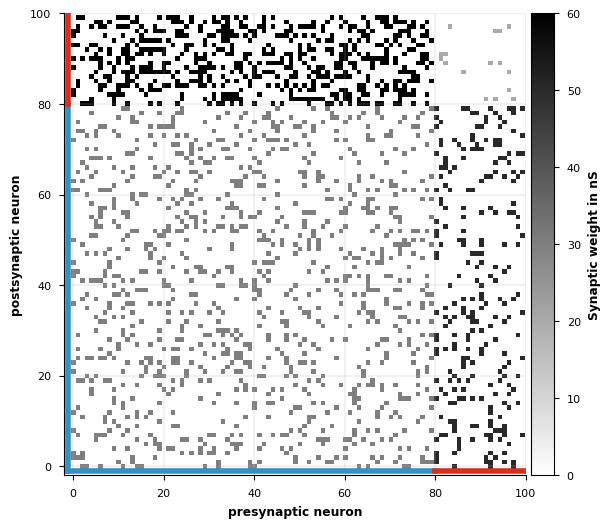

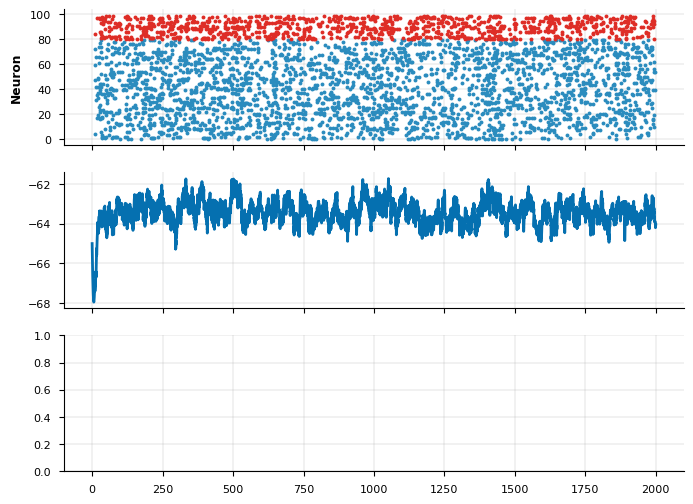

In [27]:
start_scope() # this opens our environment

n_neurons = 100



c_m = 10*nF
r_m = 1*Mohm
tau_m = c_m*r_m
tau_e = 5.26*ms
tau_i = 8*ms
E_i = -80*mV
E_e = 0*mV
E_l = -75*mV
v_threshold = -54 *mV
v_reset = -75*mV
g_l = 1/r_m

eqs = '''
dv/dt = (i_e + i_i+ i_l)/c_m : volt
i_e = g_e * (E_e - v) : amp
i_i = g_i * (E_i - v) : amp
i_l = g_l * (E_l - v) : amp
dg_e/dt = -g_e / tau_e : siemens
dg_i/dt = -g_i / tau_i : siemens
'''

input_excitation = PoissonGroup(n_neurons, rates=100*Hz, dt=0.1*ms)

neurons_exc = NeuronGroup(n_neurons*0.8, eqs, threshold='v>v_threshold', reset='v=v_reset', method='exponential_euler')
neurons_inh = NeuronGroup(n_neurons*0.2, eqs, threshold='v>v_threshold', reset='v=v_reset', method='exponential_euler')
neurons_exc.v = -65*mV
neurons_inh.v = -65*mV

excitatory_synapses = Synapses(input_excitation,neurons_exc, 'w : siemens', on_pre = 'g_e += w', name = 'excitatory_connections')
excitatory_synapses.connect(condition = 'i==j')
excitatory_synapses.w = 450*nS

inhibitory_synapses = Synapses(input_excitation,neurons_inh, 'w : siemens', on_pre = 'g_e += w', name = 'inhibitory_connections')
inhibitory_synapses.connect(condition = 'i==j')
inhibitory_synapses.w = 450*nS

e_e = Synapses(neurons_exc,neurons_exc, 'w : siemens', on_pre = 'g_e += w', name = 'rec_e_e')
e_e.connect(p=0.15)
e_e.w = 30*nS

i_e = Synapses(neurons_exc,neurons_inh, 'w : siemens', on_pre = 'g_e += w', name = 'rec_i_e')
i_e.connect(p=0.15)
i_e.w = 50*nS

e_i = Synapses(neurons_inh,neurons_exc, 'w : siemens', on_pre = 'g_i += w', name = 'rec_e_i')
e_i.connect(p=0.35)
e_i.w = 60*nS

i_i = Synapses(neurons_inh,neurons_inh, 'w : siemens', on_pre = 'g_i += w', name = 'rec_i_i')
i_i.connect(p=0.05)
i_i.w = 20*nS


W = np.full((n_neurons +2, n_neurons + 2), np.nan) # we always add + 2 to allow color annotations in plot
# Insert the values from the Synapses object
W[e_e.i[:], e_e.j[:]] = e_e.w[:]/nS
W[i_e.i[:], i_e.j[:]+len(neurons_exc)] = i_e.w[:]/nS
W[e_i.i[:]+len(neurons_exc),e_i.j[:]] = e_i.w[:]/nS
W[i_i.i[:]+len(neurons_exc),i_i.j[:]+len(neurons_exc)] = i_i.w/nS


fig, ax = plt.subplots()
im = ax.imshow(W, origin='lower', cmap='binary', vmin=0)
ax.plot([-1,-1],[-1,len(neurons_exc)], color = '#3690c0',linewidth=4)
ax.plot([-1,-1],[len(neurons_exc),n_neurons], color = '#d7301f',linewidth=4)
ax.plot([-1,len(neurons_exc)],[-1,-1], color = '#3690c0',linewidth=4)
ax.plot([len(neurons_exc),n_neurons],[-1,-1], color = '#d7301f',linewidth=4)
divider = make_axes_locatable(ax)
ax.set(
    xlim = (-2,n_neurons),
    ylim = (-2,n_neurons),
    xlabel = 'presynaptic neuron',
    ylabel = 'postsynaptic neuron')
cax = divider.append_axes('right', size='5%', pad=0.05)
cax.grid(False)
fig.colorbar(im, cax=cax, orientation='vertical', label='Synaptic weight in nS')

plt.savefig('connectivity_matrix.pdf', dpi=300, format=None, metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )


specific_excitation = PoissonGroup(n_neurons*0.1, rates=0*Hz)
specific_syn = Synapses(specific_excitation,neurons_exc, 'w : siemens', on_pre = 'g_e += w', name = 'specific_connections')
specific_syn.connect(condition = 'i==j')
specific_syn.w = 4.5*nS


M_e = SpikeMonitor(neurons_exc)
M_i = SpikeMonitor(neurons_inh)
voltage_exc = StateMonitor(neurons_exc, 'v', record=True)
rate_exc = PopulationRateMonitor(neurons_exc)
rate_inh = PopulationRateMonitor(neurons_inh)



run(2000*ms)

fig, (ax1,ax2,ax3) = plt.subplots(3, sharex=True)
ax1.plot(M_e.t/ms, M_e.i, '.', c='#2b8cbe')
ax1.plot(M_i.t/ms, M_i.i+n_neurons*0.8, '.', c='#de2d26')
ax1.set(
    ylabel = 'Neuron')
ax2.plot(voltage_exc.t/ms, np.mean((voltage_exc.v/mV),axis=0))
ax3.plot(rate_inh)
ax3.set(
    xlabel = 'Time in ms')

\begin{align}
\tau_E \frac{dr_E}{dt} &= -r_E + F_E(w_{EE}r_E -w_{EI}r_I + I_E) \\
\tau_I \frac{dr_I}{dt} &= -r_I + F_I(w_{IE}r_E -w_{II}r_I + I_I) \qquad (1)
\end{align}

In [ ]:

def dr_dt(
    dt,
    tauE = 20, tauI = 10):
    
    x = wEE * rE - wEI * rI + IE 
    drE_dt = dt * (- rE + nonlinearity_f(x, alpha, theta))/tauE

    x = wIE * rE - wII * rI + II 
    drI_dt = dt * (- rI + nonlinearity_f(x, alpha, theta))/tauI
    
    return drE_dt, drI_dt


# run the simulation for the rate model
for ii in range(time_steps):
    
    